In [1]:
# Install this package to use Colab's GPU for training
!sudo apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 3 not upgraded.
Need to get 420 MB of archives.
After this operation, 1,622 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 8s (51.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize fron

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Download and Inspect the Dataset|

In [3]:
import os

base_dir = '/content/drive/MyDrive/Colab Notebooks/data/'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/brain_tumor_dataset'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/val'))

Contents of base directory:
['val', 'brain_tumor_dataset', 'CNN_tumor.h5', '.ipynb_checkpoints']

Contents of train directory:
['no', 'yes']

Contents of validation directory:
['yes', 'no']


In [4]:
import os

train_dir = os.path.join(base_dir, 'brain_tumor_dataset')
validation_dir = os.path.join(base_dir, 'val')

# Directory with training yes/no pictures
train_yes_dir = os.path.join(train_dir, 'yes')
train_no_dir = os.path.join(train_dir, 'no')

# Directory with validation yes/no pictures
validation_yes_dir = os.path.join(validation_dir, 'yes')
validation_no_dir = os.path.join(validation_dir, 'no')

In [5]:
train_yes_fnames = os.listdir( train_yes_dir )
train_no_fnames = os.listdir( train_no_dir )

print(train_yes_fnames[:10])
print(train_no_fnames[:10])

['Y46.jpg', 'Y147.JPG', 'Y45.JPG', 'Y62.jpg', 'Y111.JPG', 'Y102.jpg', 'Y82.jpg', 'Y3.jpg', 'Y35.jpg', 'Y156.JPG']
['10 no.jpg', '11 no.jpg', '1 no.jpeg', '6 no.jpg', '37 no.jpg', '43 no.jpg', '2 no.jpeg', '18 no.jpg', '30 no.jpg', '32 no.jpg']


In [6]:
print('total training yes images :', len(os.listdir(      train_yes_dir ) ))
print('total training no images :', len(os.listdir(      train_no_dir ) ))

print('total validation yes images :', len(os.listdir( validation_yes_dir ) ))
print('total validation no images :', len(os.listdir( validation_no_dir ) ))

total training yes images : 155
total training no images : 98
total validation yes images : 155
total validation no images : 98


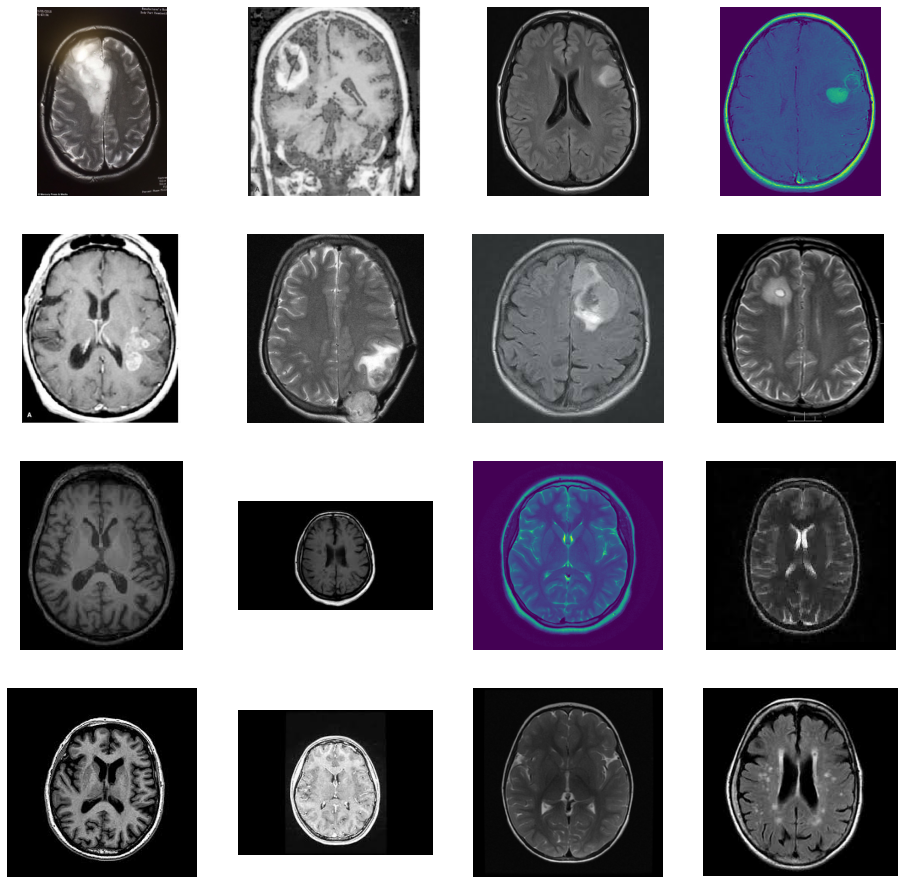

In [7]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_yes_pix = [os.path.join(train_yes_dir, fname) 
                for fname in train_yes_fnames[ pic_index-8:pic_index] 
               ]

next_no_pix = [os.path.join(train_no_dir, fname) 
                for fname in train_no_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_yes_pix+next_no_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [8]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(256, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [10]:
from tensorflow.keras.optimizers import RMSprop,Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255 , 
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
test_datagen  = ImageDataGenerator( rescale = 1.0/255. ,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest' )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (224, 224))

Found 253 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


In [12]:
 !wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-11-14 16:06:23--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/inception_v3_weigh 100%[===================>]  83.84M  32.0MB/s    in 2.6s    

2022-11-14 16:06:26 (32.0 MB/s) - ‘/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [13]:
local_weights_file = '/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [14]:
from tensorflow.keras.applications.inception_v3 import  InceptionV3
from tensorflow.keras import  layers

In [15]:
pre_train_model=InceptionV3( input_shape=(224 ,224,3),
                            include_top=False,
                            weights=None)

In [16]:
pre_train_model.load_weights(local_weights_file)

In [17]:
for layer in pre_train_model.layers:
  layers.trainable=False

In [18]:
pre_train_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_3[0][0]']               
 alization)                     )                                                      

In [19]:
last_layer=pre_train_model.get_layer('mixed7')
last_output=last_layer.output

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

In [21]:
x=layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)         
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)              
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)  

In [22]:
model2= Model(pre_train_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_3[0][0]']               
 alization)                     )                                                             

In [23]:
model2.compile(optimizer = Adam(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [24]:
history2=model2.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=5,
    validation_steps=5,
    validation_data=validation_generator
)

Epoch 1/5
10/10 [==============================] - 69s 6s/step - loss: 0.7353 - accuracy: 0.5699 - val_loss: 0.5786 - val_accuracy: 0.7100
Epoch 2/5
10/10 [==============================] - 28s 3s/step - loss: 0.5049 - accuracy: 0.7550 - val_loss: 0.3609 - val_accuracy: 0.8400
Epoch 3/5
10/10 [==============================] - 18s 2s/step - loss: 0.3756 - accuracy: 0.8100 - val_loss: 0.2358 - val_accuracy: 0.9100
Epoch 4/5
10/10 [==============================] - 10s 1s/step - loss: 0.3001 - accuracy: 0.8705 - val_loss: 0.7472 - val_accuracy: 0.7900
Epoch 5/5
10/10 [==============================] - 10s 1s/step - loss: 0.1959 - accuracy: 0.9200 - val_loss: 0.1257 - val_accuracy: 0.9600


Text(0.5, 1.0, 'Training and validation loss')

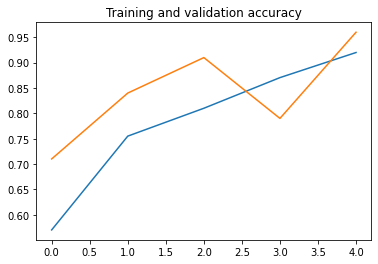

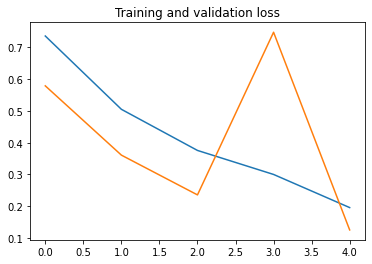

In [25]:
acc      = history2.history[     'accuracy' ]
val_acc  = history2.history[ 'val_accuracy' ]
loss     = history2.history[    'loss' ]
val_loss = history2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [26]:
model2.save('/content/drive/MyDrive/Colab Notebooks/data/InceptionV3.h5')